## Import libraries

In [1]:
import os
import random
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch

import tensorflow as tf
import tensorflow_datasets as tfds

from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import TrainingArguments, Trainer

import datasets
from datasets import load_metric

## Define Functions

In [2]:
def show_img(data, class_names):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.asarray(data['image'][i]))
        plt.title(class_names[str(data['label'][i])])
        plt.axis("off")

In [3]:
# Defing a function print shape of dataset (loaded from keras dataset)
def dataset_shape(dataset):
    for image_batch, labels_batch in dataset:
        print('images: ', image_batch.shape)
        print('labels: ', labels_batch.shape)
        break

In [4]:
def data_files ():
    data_size = 0
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
#             print(os.path.join(dirname, filename))
            data_size += 1
    return data_size

In [5]:
def gen_encoding(batch):
    inputs = feature_extractor([x for x in batch['image']], return_tensors='pt')
    inputs['label'] = batch['label']
    
    return inputs

In [6]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [7]:
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

## Define Variables

In [8]:
# hyperparameter
DATA_DIR='../input/workoutexercises-images'
OUTPUT_DIR='./trainingOutput'
height=256
width=256
channels=3
batch_size=64
seed=42
img_shape=(height, width, channels)
img_size=(height, width)
model_id='google/vit-base-patch16-224'
# model_id='./trainingOutput/checkpoint-200'
metric=load_metric("accuracy")
# class_names=['bench press', 'biceps curl', 'chest fly machine', 'deadlift', 'incline bench press', 'lat pulldown', 'push-up', 'tricep pushdown']

In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
# model = ViTForImageClassification.from_pretrained(model_id)

# print(feature_extractor)
# print(model)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [10]:
DATASET_SIZE=data_files()

train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

print(DATASET_SIZE)
print(train_size)
print(val_size)
print(test_size)

2186
1748
218
218


## Preprocessing

In [11]:
# Load image (loaded from datasets)
dataset = datasets.load_dataset('imagefolder', data_dir='../input/workoutexercises-images/')
ds = dataset['train']
ds = ds.shuffle(seed=seed)
ds['label'][:10]

Resolving data files:   0%|          | 0/2186 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-e9e849ca9c3bbe45/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

[0, 0, 7, 5, 0, 3, 4, 5, 2, 5]

In [12]:
# Split data (loaded from datasets)
train_dsX = ds['image'][0:train_size]
val_dsX = ds['image'][train_size:train_size+val_size]
test_dsX = ds['image'][train_size+val_size:DATASET_SIZE]

print('train_dsX: ', len(train_dsX), type(train_dsX))
print('val_dsX: ', len(val_dsX), type(val_dsX))
print('test_dsX: ', len(test_dsX), type(test_dsX))

train_dsY = ds['label'][0:train_size]
val_dsY = ds['label'][train_size:train_size+val_size]
test_dsY = ds['label'][train_size+val_size:DATASET_SIZE]

print('train_dsY: ', len(train_dsY), type(train_dsY))
print('val_dsY: ', len(val_dsY), type(val_dsY))
print('test_dsY: ', len(test_dsY), type(test_dsY))

train_ds = datasets.Dataset.from_dict({'image': train_dsX, 'label': train_dsY})
test_ds = datasets.Dataset.from_dict({'image': test_dsX, 'label': test_dsY})
val_ds = datasets.Dataset.from_dict({'image': val_dsX, 'label': val_dsY})

print('train_ds: ', train_ds)
print('test_ds: ', test_ds)
print('val_ds: ', val_ds)

train_dsX:  1748 <class 'list'>
val_dsX:  218 <class 'list'>
test_dsX:  220 <class 'list'>
train_dsY:  1748 <class 'list'>
val_dsY:  218 <class 'list'>
test_dsY:  220 <class 'list'>
train_ds:  Dataset({
    features: ['image', 'label'],
    num_rows: 1748
})
test_ds:  Dataset({
    features: ['image', 'label'],
    num_rows: 220
})
val_ds:  Dataset({
    features: ['image', 'label'],
    num_rows: 218
})


In [13]:
class_names = ds.features["label"].names
id2label = {str(i): label for i, label in enumerate(class_names)}
label2id = {v: k for k, v in id2label.items()}

In [14]:
pt_train_ds = train_ds.with_transform(gen_encoding)
pt_val_ds = val_ds.with_transform(gen_encoding)
pt_test_ds = test_ds.with_transform(gen_encoding)

## View Dataset

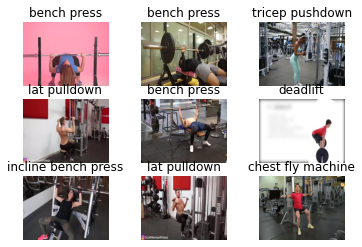

In [15]:
show_img(train_ds, id2label)

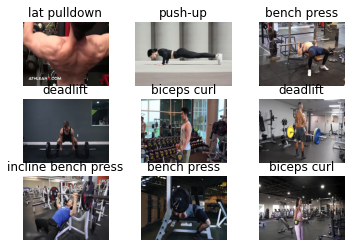

In [16]:
show_img(test_ds, id2label)

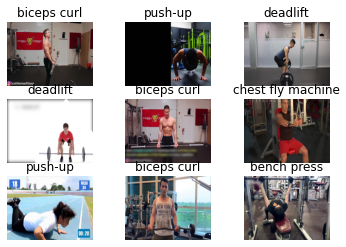

In [17]:
show_img(val_ds, id2label)

## Define Model

In [18]:
model = ViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
training_args = TrainingArguments(
  output_dir=OUTPUT_DIR,
  per_device_train_batch_size=batch_size,
  evaluation_strategy="steps",
  num_train_epochs=8,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=pt_train_ds,
    eval_dataset=pt_val_ds,
    tokenizer=feature_extractor
)

## Train Model

In [21]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1748
  Num Epochs = 8
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 224


Step,Training Loss,Validation Loss,Accuracy
100,0.005000,0.018345,0.990826
200,0.000300,0.024314,0.986239


***** Running Evaluation *****
  Num examples = 218
  Batch size = 8
Saving model checkpoint to ./trainingOutput/checkpoint-100
Configuration saved in ./trainingOutput/checkpoint-100/config.json
Model weights saved in ./trainingOutput/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./trainingOutput/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 218
  Batch size = 8
Saving model checkpoint to ./trainingOutput/checkpoint-200
Configuration saved in ./trainingOutput/checkpoint-200/config.json
Model weights saved in ./trainingOutput/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./trainingOutput/checkpoint-200/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./trainingOutput/checkpoint-100 (score: 0.018344877287745476).
Saving model checkpoint to ./trainingOutput
Configuration saved in ./trainingOutput/config.json
Model weights saved in ./tr

***** train metrics *****
  epoch                    =          8.0
  total_flos               = 1009280101GF
  train_loss               =       0.0513
  train_runtime            =   4:25:52.97
  train_samples_per_second =        0.877
  train_steps_per_second   =        0.014


In [22]:
metrics = trainer.evaluate(pt_test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** eval metrics *****
  epoch                   =        8.0
  eval_accuracy           =     0.9864
  eval_loss               =     0.0361
  eval_runtime            = 0:01:14.45
  eval_samples_per_second =      2.955
  eval_steps_per_second   =      0.376


## Test fine tuned model

In [23]:
model_id='./trainingOutput/checkpoint-200'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
model = ViTForImageClassification.from_pretrained(model_id)

loading feature extractor configuration file ./trainingOutput/checkpoint-200/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

loading configuration file ./trainingOutput/checkpoint-200/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "bench press",
    "1": "biceps curl",
    "2": "chest fly machine",
    "3": "deadlift",
    "4": "incline bench press",
    "5": "lat pulldown",
    "6": "push-up",
    "7": "tricep pushdown"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediat

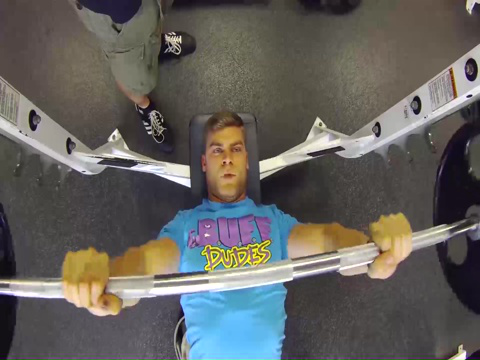

Predicted class: bench press


In [24]:
image = test_ds[random.randrange(len(test_ds))]['image']
display(image)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])